In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://www.ibm.com/think/topics/langgraph',
  'content': 'Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. Nodes can be thought of as “actors” that interact with each other in a specific way. For example, to add nodes for tool calling, one can use the ToolNode. Another example, the next node, refers to the node that will be executed following the current one.\n\nEdges: Edges are a function within Python that determines which node to execute next based on the current state. Edges can be conditional branches or fixed transitions.\n\n#### Tools\n\nRAG: Retrieval-augmented generation (RAG) combines the power of LLMs with contextual information from external sources by retrieving relevant documents, which are then used as input for answer generation.'},
 {'url': 'https://qiita.com/KUROMAGOORO/items/b37c28dbddee4314153e',
  'content': '| LangGraph の要素 | 説明 |\n --- |\n| State | 会話履歴や処理結果などを保持し、ノード間で共有・更新出来る。これにより、長い対話や複数ステップの処理が安定して行える。 |\

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)


In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

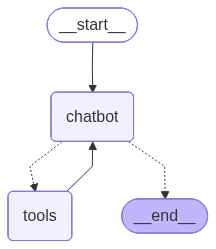

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは
こんにちは！今日はどんなことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に知りたいことはありますか？
1メートル以上の魚は？

[{"url": "https://ailovei.com/?p=36629", "content": "### 22.ウバザメ\n\nすべての魚類の中で2番目に大きい種である。最大で13.7mに達する。  \n この大きな口は、海水ごと丸呑みにして、プランクトンを大量摂取するためにある。  \n 世界中の海に広く分布しており、性質がおとなしいことから、ダイビングでの目玉として扱われている。\n\n### 23.ジンベエザメ\n\n世界最大の魚類で、全長は最大で20m近くに達することもある。  \n 世界中の暖かい海域に生息しており、動きが緩慢でプランクトンしか食べないので、人に危害を与えることはほとんど無い。\n\n### 24.アカマンボウ\n\n全長2m、体重270kgに達するリュウグウノツカイの近縁種。世界中の暖かい海域に生息している。  \n マンボウに似ているが、無縁である。マンボウと違って尾びれをもっており、胸ヒレが垂直である。  \n 近年では、マグロの代用魚として注目を浴びている。\n\n### 25.マンボウ\n\n最大で全長3.3 m、体重2.3t に達する世界最大級の硬骨魚。  \n 水深0～800mの温帯海域を移動して生活している。  \n 皮膚は厚い粘液で覆われており、おびただしい量の寄生虫が付着している。\n\n### 26.アハイア・グランディ\n\n淡水エイとしては2番目に大きいとされる種。  \n 全長は約1.5ｍ、体重は200kg前後まで成長する。  \n 球状の模様と尾が他の種よりも短いのが特徴である。  \n 他のエイと同様に尾に毒針を持っている。写真のしっぽのトゲに毒がある。\n\n### 27.ヒマンチュラ・チャオプラヤ\n\n世界最大の淡水エイでインドネシアやボルネオの河川で見られる種。  \n その大きさは最大全長2m、体重600kgを超える。  \n 他のエイと同様に尾の付け根に毒を持っており、刺されると最悪呼吸困難に陥る。  \n →次のページがあります\n\nスポンサーリンク\n\n動物 [...] ### 7.クロカジキ\n\n最大全長4m、体重500k